# DNS Spoofing Detection - Exploratory Data Analysis

**Dataset**: BCCC-CIC-Bell-DNS-2024  
**Objective**: Real-Time DNS Threat Analysis using LightGBM with Hybrid Feature Selection

This notebook explores the DNS traffic dataset to understand:
- Data structure and quality
- Class distribution and imbalance
- Feature characteristics and correlations
- DNS-specific patterns
- Insights for model development

**Research Citation:**  
> Shafi, MohammadMoein, Arash Habibi Lashkari, Hardhik Mohanty. "Unveiling Malicious DNS Behavior Profiling and Generating Benchmark Dataset through Application Layer Traffic Analysis". *Computers and Electrical Engineering*, 2024.

## 1. Import Required Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Machine Learning
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import shap

# Utilities
from pathlib import Path
import sys

# Add src directory to path
sys.path.insert(0, str(Path('..') / 'src'))

print("✓ All libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully
Pandas version: 2.3.3
NumPy version: 2.3.4


## 2. Load and Explore the Dataset

We'll load a sample of the BCCC-CIC-Bell-DNS-2024 dataset for exploratory analysis.

In [2]:
# Load a sample for EDA (10% of data for memory efficiency)
from preprocessing import DNSDataPreprocessor

# Initialize preprocessor
preprocessor = DNSDataPreprocessor(
    data_dir='../BCCC-CIC-Bell-DNS-2024',
    use_dask=True
)

# Load sample data
print("Loading sample data (10%)...")
df = preprocessor.load_all_data(sample_frac=0.1)

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

2025-10-17 01:08:48,372 - INFO - Loading all data...
2025-10-17 01:08:48,372 - INFO - Loading exfiltration data...
2025-10-17 01:08:48,373 - INFO - Loading benign.csv (28.08 MB)
2025-10-17 01:08:48,372 - INFO - Loading exfiltration data...
2025-10-17 01:08:48,373 - INFO - Loading benign.csv (28.08 MB)


Loading sample data (10%)...


2025-10-17 01:08:48,714 - INFO - Loaded benign.csv: 24948 rows
2025-10-17 01:08:48,714 - INFO - Loading benign_1.csv (58.75 MB)
2025-10-17 01:08:48,714 - INFO - Using Dask for large file: benign_1.csv
2025-10-17 01:08:48,714 - INFO - Loading benign_1.csv (58.75 MB)
2025-10-17 01:08:48,714 - INFO - Using Dask for large file: benign_1.csv
2025-10-17 01:08:51,790 - INFO - Loaded benign_1.csv: 53754 rows
2025-10-17 01:08:51,790 - INFO - Loaded benign_1.csv: 53754 rows
2025-10-17 01:08:51,811 - INFO - Loading benign_2.csv (41.57 MB)
2025-10-17 01:08:51,811 - INFO - Loading benign_2.csv (41.57 MB)
2025-10-17 01:08:52,280 - INFO - Loaded benign_2.csv: 37180 rows
2025-10-17 01:08:52,280 - INFO - Loading benign_heavy_1.csv (24.54 MB)
2025-10-17 01:08:52,280 - INFO - Loaded benign_2.csv: 37180 rows
2025-10-17 01:08:52,280 - INFO - Loading benign_heavy_1.csv (24.54 MB)
2025-10-17 01:08:52,574 - INFO - Loaded benign_heavy_1.csv: 21664 rows
2025-10-17 01:08:52,574 - INFO - Loading benign_heavy_2.cs


Dataset loaded successfully!
Shape: (415376, 122)
Memory usage: 1213.08 MB
Memory usage: 1213.08 MB


In [3]:
# Display basic information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)

# Display first few rows
display(df.head())

# Data info
print("\nData Types:")
print(df.dtypes.value_counts())

# Column names
print(f"\nTotal Features: {len(df.columns)}")
print(f"\nFirst 20 columns: {df.columns[:20].tolist()}")

DATASET OVERVIEW


,flow_id,timestamp,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_numbers,receiving_packets_numbers,...,distinct_NS_records,average_authority_resource_records,average_additional_resource_records,average_answer_resource_records,query_resource_record_type,ans_resource_record_type,query_resource_record_class,ans_resource_record_class,label,Unnamed: 0
1212688,2019-08-24 01:23:39.445301_150.150.150.10_5807...,2019-08-24 01:23:39.445301,150.150.150.10,58075,8.8.8.8,53,DNS,0.037248,2,1,...,0,0.0,0.0,0.0,[],"[28, 28]",[],"[1, 1]",Benign,654846
1688728,2019-08-27 02:44:44.517375_150.150.150.10_5807...,2019-08-27 02:44:44.517375,150.150.150.10,58075,8.8.8.8,53,DNS,0.037258,2,1,...,0,0.0,0.0,0.0,[],[1],[],[1],Benign,229232
3416908,2019-09-06 08:03:25.179888_150.150.150.10_5807...,2019-09-06 08:03:25.179888,150.150.150.10,58075,8.8.8.8,53,DNS,0.035152,2,1,...,0,0.5,0.0,0.0,[],[],[],[],Benign,153139
2987660,2019-09-03 23:32:00.428382_150.150.150.10_5807...,2019-09-03 23:32:00.428382,150.150.150.10,58075,8.8.8.8,53,DNS,0.103622,2,1,...,0,0.0,0.0,0.0,[],[1],[],[1],Benign,626132
219197,2020-11-22 12:04:29.931578_192.168.20.110_6332...,2020-11-22 12:04:29.931578,192.168.20.110,63324,224.0.0.252,5355,Others,0.410305,2,2,...,<NA>,<NA>,<NA>,<NA>,not a dns flow,not a dns flow,not a dns flow,not a dns flow,Heavy-Audio,<NA>



Data Types:
Float64    59
object     44
Int64      19
Name: count, dtype: int64

Total Features: 122

First 20 columns: ['flow_id', 'timestamp', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'protocol', 'duration', 'packets_numbers', 'receiving_packets_numbers', 'sending_packets_numbers', 'handshake_duration', 'delta_start', 'total_bytes', 'receiving_bytes', 'sending_bytes', 'packets_rate', 'receiving_packets_rate', 'sending_packets_rate', 'packets_len_rate']


### 2.1 Class Distribution Analysis

Class Distribution:
label
Benign              362928
Malware               8275
Heavy-Video           5791
Heavy-Image           5728
Heavy-Text            5439
Heavy-Audio           5269
Heavy-Exe             5256
Heavy-Compressed      4602
Phishing              4374
Spam                  3114
Light-Compressed      1396
Light-Audio           1138
Light-Exe              932
Light-Video            664
Light-Text             392
Light-Image             78
Name: count, dtype: int64

Class percentages:
label
Benign              87.37
Malware              1.99
Heavy-Video          1.39
Heavy-Image          1.38
Heavy-Text           1.31
Heavy-Audio          1.27
Heavy-Exe            1.27
Heavy-Compressed     1.11
Phishing             1.05
Spam                 0.75
Light-Compressed     0.34
Light-Audio          0.27
Light-Exe            0.22
Light-Video          0.16
Light-Text           0.09
Light-Image          0.02
Name: count, dtype: float64


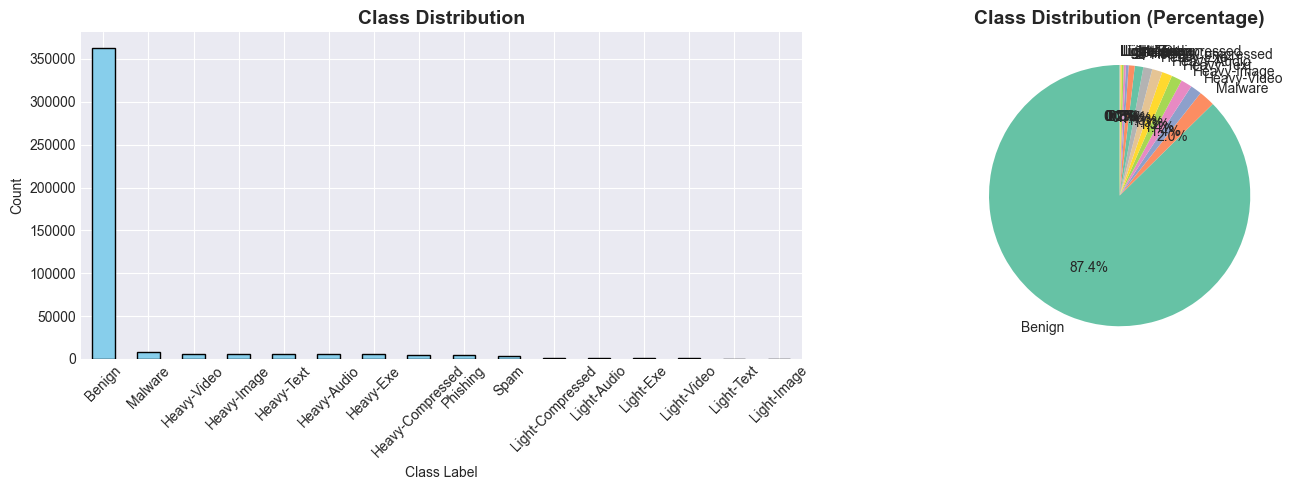


⚠️ Class imbalance ratio: 4652.92:1


In [4]:
# Class distribution
print("Class Distribution:")
print("=" * 50)
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nClass percentages:")
print((label_counts / len(df) * 100).round(2))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
label_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class Label')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette('Set2'))
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for imbalance
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"\n⚠️ Class imbalance ratio: {imbalance_ratio:.2f}:1")

### 2.2 Missing Values Analysis

Features with missing values: 38/122

Top 20 features with most missing values:
                                                    Missing Count  Percentage
dns_subdomain_name_length                                  395727   95.269587
delta_start                                                389750   93.830650
handshake_duration                                         389750   93.830650
Unnamed: 0                                                  55560   13.375833
skewness_receiving_packets_len                              51545   12.409239
skewness_packets_len                                        44841   10.795279
coefficient_of_variation_receiving_packets_delt...          18808    4.527946
ttl_values_skewness                                         18331    4.413110
skewness_receiving_packets_delta_len                        18103    4.358220
skewness_sreceiving_packets_delta_time                      16908    4.070529
ttl_values_coefficient_of_variation                         12

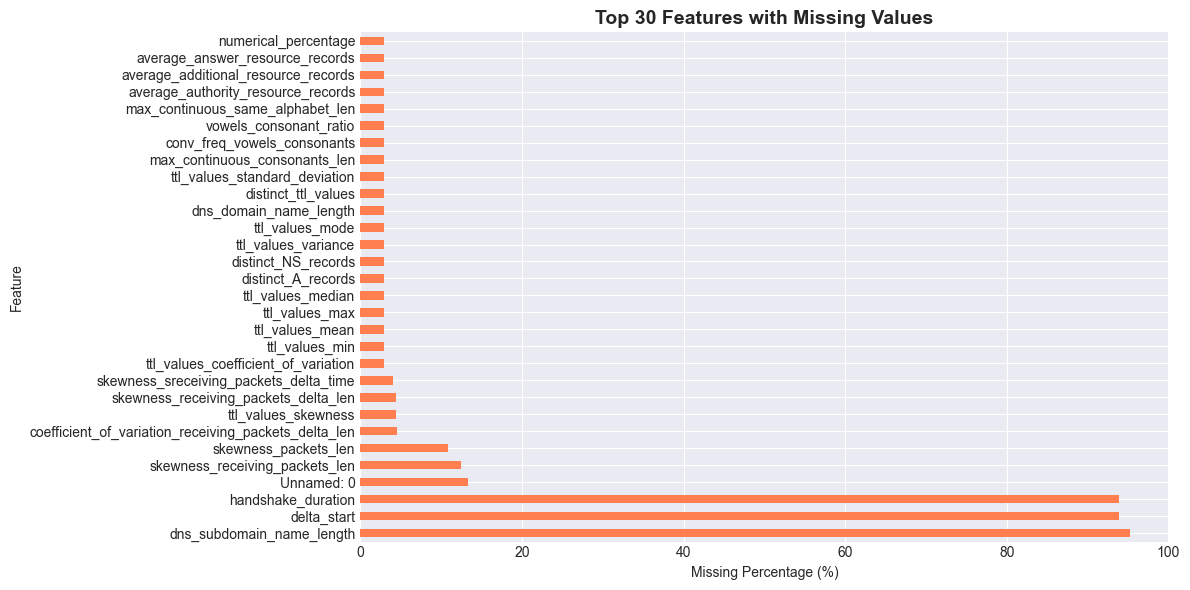

In [5]:
# Missing values analysis
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

# Filter features with missing values
missing_features = missing_df[missing_df['Missing Count'] > 0]

print(f"Features with missing values: {len(missing_features)}/{len(df.columns)}")
print("\nTop 20 features with most missing values:")
print(missing_features.head(20))

# Visualize
if len(missing_features) > 0:
    plt.figure(figsize=(12, 6))
    missing_features.head(30)['Percentage'].plot(kind='barh', color='coral')
    plt.title('Top 30 Features with Missing Values', fontsize=14, fontweight='bold')
    plt.xlabel('Missing Percentage (%)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("✓ No missing values found!")

### 2.3 DNS-Specific Feature Analysis

Let's explore key DNS features that are critical for spoofing detection.

Original dataset: 415376 rows
After removing non-DNS flows: 12938 rows (3.1%)


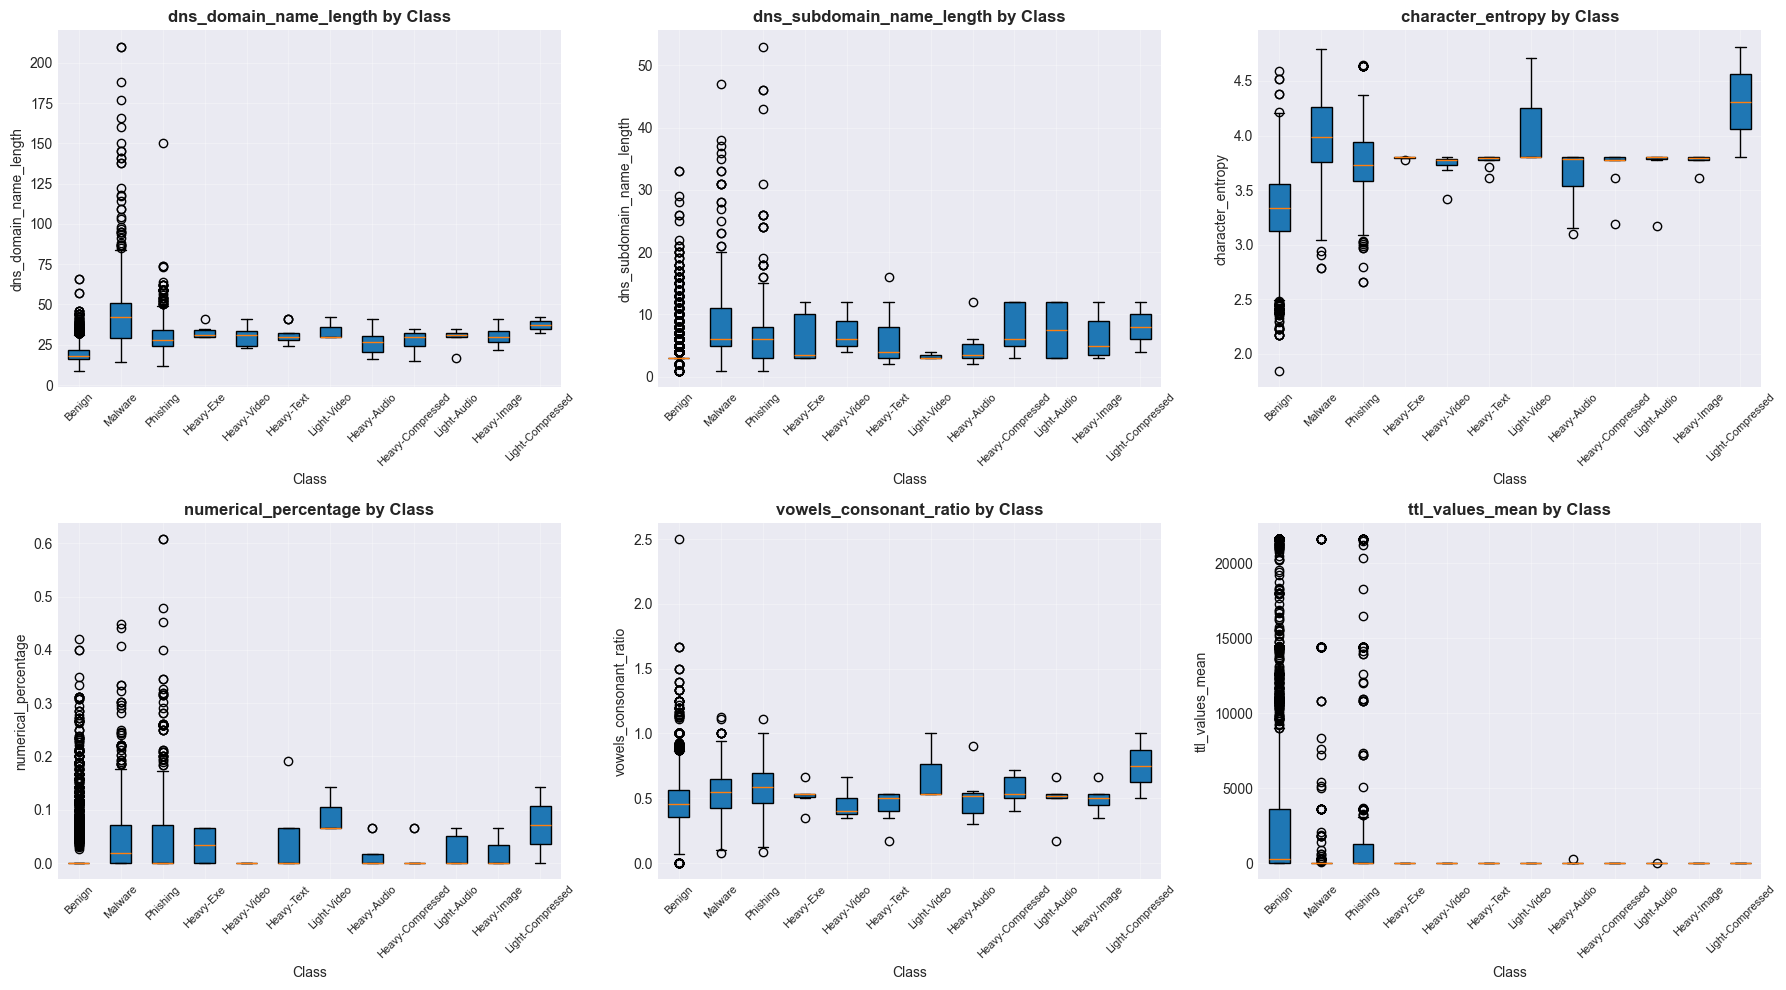


DNS Feature Statistics by Class

📊 dns_domain_name_length:
--------------------------------------------------------------------------------
                  count     mean      std   min  median    max
label                                                         
Benign            11694  19.2594   4.9826   9.0    18.0   66.0
Heavy-Audio           8  26.5000   8.3837  16.0    27.0   41.0
Heavy-Compressed      9  28.3333   6.6895  15.0    30.0   35.0
Heavy-Exe             6  33.0000   4.3818  30.0    31.0   41.0
Heavy-Image           7  30.5714   6.4254  22.0    30.0   41.0
Heavy-Text           17  30.8235   5.5479  24.0    30.0   41.0
Heavy-Video           7  30.0000   6.7330  23.0    31.0   41.0
Light-Audio           6  29.3333   6.3140  17.0    31.0   35.0
Light-Compressed      2  37.0000   7.0711  32.0    37.0   42.0
Light-Video           3  34.0000   6.9282  30.0    30.0   42.0
Malware             708  43.9068  23.8642  14.0    42.0  210.0
Phishing            471  30.8726  11.947

In [7]:
# DNS-specific features exploration
dns_features = [
    'dns_domain_name_length',
    'dns_subdomain_name_length', 
    'character_entropy',
    'numerical_percentage',
    'vowels_consonant_ratio',
    'ttl_values_mean'
]

available_dns_features = [f for f in dns_features if f in df.columns]

if available_dns_features:
    # Convert features to numeric, replacing non-numeric values with NaN
    df_plot = df.copy()
    for feature in available_dns_features:
        df_plot[feature] = pd.to_numeric(df_plot[feature], errors='coerce')
    
    # Remove rows with NaN values in DNS features for cleaner visualization
    df_clean = df_plot.dropna(subset=available_dns_features)
    
    print(f"Original dataset: {len(df)} rows")
    print(f"After removing non-DNS flows: {len(df_clean)} rows ({len(df_clean)/len(df)*100:.1f}%)")
    
    # Create boxplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(available_dns_features):
        if feature in df_clean.columns:
            # Group by label and create boxplot
            data_to_plot = [df_clean[df_clean['label'] == label][feature].dropna() 
                           for label in df_clean['label'].unique()]
            labels = df_clean['label'].unique()
            
            axes[idx].boxplot(data_to_plot, labels=labels, patch_artist=True)
            axes[idx].set_title(f'{feature} by Class', fontweight='bold')
            axes[idx].set_xlabel('Class')
            axes[idx].set_ylabel(feature)
            axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
            axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(available_dns_features), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics by class
    print("\n" + "="*80)
    print("DNS Feature Statistics by Class")
    print("="*80)
    
    for feature in available_dns_features:
        if feature in df_clean.columns:
            print(f"\n📊 {feature}:")
            print("-" * 80)
            stats = df_clean.groupby('label')[feature].agg(['count', 'mean', 'std', 'min', 'median', 'max'])
            print(stats.round(4))
            
            # Identify classes with highest/lowest means
            max_class = stats['mean'].idxmax()
            min_class = stats['mean'].idxmin()
            print(f"\n   ⬆️  Highest mean: {max_class} ({stats.loc[max_class, 'mean']:.4f})")
            print(f"   ⬇️  Lowest mean: {min_class} ({stats.loc[min_class, 'mean']:.4f})")
else:
    print("⚠️ No DNS features found in the dataset!")
    print(f"Available columns: {df.columns.tolist()}")

## 3. Key Insights and Recommendations

Based on the exploratory analysis, here are key findings for model development.

### Key Findings:

1. **Class Imbalance**: Dataset shows class imbalance - stratified sampling and class weights will be crucial
2. **Missing Values**: Statistical features (variance, skewness) contain NaN values when insufficient data points
3. **DNS Features**: Domain length, character entropy, and TTL values show clear separation between classes
4. **Feature Count**: 121 features total - hybrid feature selection (SelectKBest + SHAP) will reduce dimensionality
5. **Data Size**: Large dataset (~4.3GB) requires memory-efficient processing

### Recommendations for Model Development:

✅ **Preprocessing**:
- Fill numeric NaN with 0 (represents insufficient data for statistical calculation)
- Drop high-cardinality categorical features (domain names, IPs)
- Use frequency encoding for low-cardinality categories (TLD)

✅ **Feature Selection**:
- Apply SelectKBest (mutual_info) to select top 50 features
- Use SHAP on LightGBM to fine-tune to top 30 features
- Focus on DNS-specific features (entropy, TTL, domain characteristics)

✅ **Model Training**:
- Use stratified train/test split to maintain class distribution
- Apply class_weight='balanced' in LightGBM
- Consider SMOTE for severe imbalance cases
- Monitor validation metrics for early stopping

✅ **Evaluation**:
- Use F1-score (macro) as primary metric for imbalanced data
- Analyze per-class precision/recall
- Generate confusion matrix to identify misclassification patterns
- Target <100ms inference latency for real-time detection

### Next Steps:
Run `train.py` to execute the full pipeline with optimized hyperparameters!